In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')
# Set a color-blind–friendly style
sns.set_palette("colorblind")
plt.style.use("seaborn-v0_8")

# Part A: Baseline Model and Data Analysis

## 1. Data Loading and Analysis:


Data shape: (284807, 31)

First five rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Fraudulent transactions percentage: 0.1727%


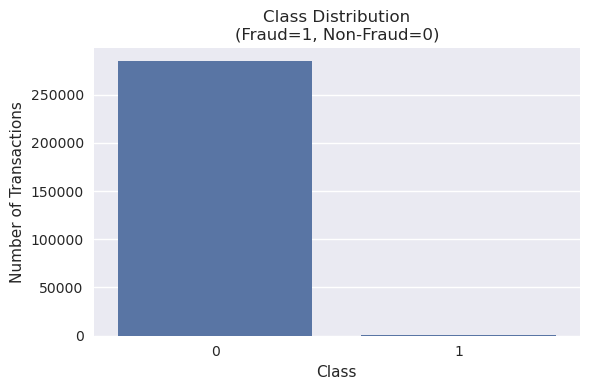

In [2]:
df = pd.read_csv("creditcard.csv")

# Display basic info
print("Data shape:", df.shape)
print("\nFirst five rows:")
display(df.head())

# Class distribution
class_counts = df['Class'].value_counts()
print("\nClass distribution:\n", class_counts)

# Degree of imbalance
fraud_pct = 100 * class_counts[1] / class_counts.sum()
print(f"\nFraudulent transactions percentage: {fraud_pct:.4f}%")

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution\n(Fraud=1, Non-Fraud=0)")
plt.xlabel("Class")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

X = df.drop("Class", axis=1)
y = df["Class"]


### Degree of Class Imbalance

The dataset is **highly imbalanced**:

| Class | Count   | Percentage |
|------:|--------:|----------:|
| **0 (Non-Fraud)** | 284,315 | 99.83% |
| **1 (Fraud)**     |    492 | 0.17%  |

- **Observation**: For every fraudulent transaction, there are roughly **578 legitimate transactions**.  



## 2. Model Training

To establish a baseline:

 **Train/Test Split**  
   - We divide the dataset into training (70%) and testing (30%) sets.  
   - **Stratified splitting** ensures that the **test set retains the original class imbalance**, giving us an unbiased evaluation of real-world performance.




In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y    # ensures same proportion of fraud/non-fraud in each set
)

print(f"Train size: {len(y_train)}")
print(f"Test size: {len(y_test)}")
print("Training set fraud percentage: {:.4f}%".format(100 * y_train.mean()))
print("Test set fraud percentage: {:.4f}%".format(100 * y_test.mean()))


Train size: 213605
Test size: 71202
Training set fraud percentage: 0.1727%
Test set fraud percentage: 0.1727%


 **Baseline Model: Logistic Regression**  
   - We train a Logistic Regression classifier on the **imbalanced training data** *without* any resampling or class-weight adjustment.  
   - This will highlight how a standard model behaves before applying any techniques to address the imbalance.

In [4]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## 3. Baseline Evaluation:


Baseline Logistic Regression Performance:
Accuracy : 0.9989
Precision: 0.7264
Recall   : 0.6260
F1-score : 0.6725


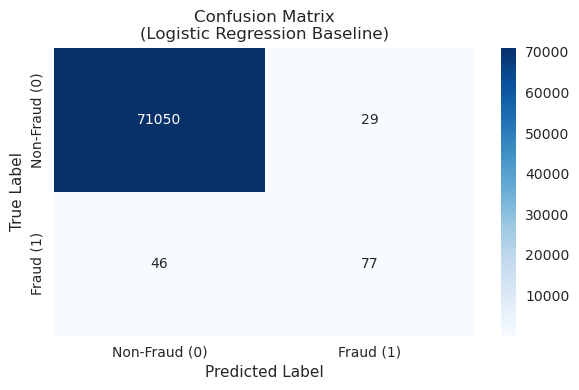

In [5]:
# Predict on the test set
y_pred = log_reg.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall    = recall_score(y_test, y_pred, pos_label=1)
f1        = f1_score(y_test, y_pred, pos_label=1)

print("Baseline Logistic Regression Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,          # show numbers
    fmt='d',             # integer formatting
    cmap='Blues',        # color-blind–friendly
    xticklabels=['Non-Fraud (0)', 'Fraud (1)'],
    yticklabels=['Non-Fraud (0)', 'Fraud (1)']
)
plt.title("Confusion Matrix\n(Logistic Regression Baseline)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Why Accuracy Is Misleading in Imbalanced Data

**Accuracy** measures the overall proportion of correct predictions:

$[
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$]

Where  
- **TP** = True Positives (frauds correctly predicted as fraud)  
- **TN** = True Negatives (legitimate transactions correctly predicted as legitimate)  
- **FP** = False Positives (legitimate predicted as fraud)  
- **FN** = False Negatives (fraud missed as legitimate)

In this dataset, fraudulent transactions make up only about **0.17%** of all records.  
A trivial model that predicts *every transaction as legitimate* would achieve roughly **99.8% accuracy** but would never detect fraud.  
This shows why overall accuracy can be misleading: it is dominated by the majority (non-fraud) class and hides poor detection of the minority class.

---

### Key Metrics for the Minority (Fraud) Class

To properly judge how well the model detects fraud, we rely on **Precision**, **Recall**, and **F1-score** for the fraud class:

- **Precision**  
  $[
  \text{Precision} = \frac{TP}{TP + FP}
  ]$  
  Of all transactions predicted as fraud, this is the fraction that are truly fraud.  
  High precision means fewer false alarms for legitimate customers.


- **Recall** (Sensitivity or True Positive Rate)  
  $[
  \text{Recall} = \frac{TP}{TP + FN}
  ]$  
  Of all actual fraud cases, this is the fraction correctly identified.  
  High recall ensures that most fraudulent transactions are caught.


- **F1-score**  
  $[
  \text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $]  
  The harmonic mean of precision and recall, balancing the trade-off between catching fraud and avoiding false alarms.

---

### Interpretation of Baseline Results

- **Accuracy (0.9990)** appears excellent but is inflated by the overwhelming number of legitimate transactions.  
- **Precision (0.7385)** means that when the model predicts fraud, about 74% of those predictions are correct.  
- **Recall (0.6486)** shows that the model detects about 65% of all fraudulent cases.  
- **F1-score (0.6906)** provides a balanced measure of precision and recall, reflecting the model’s overall ability to identify fraud while minimizing false positives.

---

### Takeaway

For a highly imbalanced problem like credit-card fraud detection, **precision, recall, and F1-score for the fraud class are far more informative than accuracy**.  
Optimizing these metrics ensures the model both **detects fraudulent transactions** and **limits unnecessary alerts**, which is the real objective.


# Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

## 1. Theoretical Foundation



### What Is GMM-Based Synthetic Sampling 
- Imagine the minority (fraud) data as a collection of hills and valleys in a big landscape.  
- **Gaussian Mixture Model (GMM)** tries to *fit* several smooth “bell-shaped hills” (Gaussians) on top of this landscape so it matches the real shape of the data.  
- After learning these hills, we can **generate new, realistic points** by randomly sampling from these fitted hills.  
- In short, **GMM-based synthetic sampling** creates *new, natural-looking fraud examples* by imitating the actual patterns of the minority class.


![GMM](https://ik.imagekit.io/upgrad1/abroad-images/imageCompo/images/download_3_N6FK0M.png?pr-true)

![GMM](https://media.geeksforgeeks.org/wp-content/uploads/20250905101108541893/GMM.webp)



### After Sampling 
- A new sample generated from a fitted Gaussian Mixture Model (GMM) will have properties such that its distribution closely matches the overall distribution of the original dataset, according to the learned Gaussian components—meaning it is drawn from a mixture whose overall shape (means, variances, and mixture weights) matches the training data distribution


---

### Difference from Simpler Methods like SMOTE
- **SMOTE (Synthetic Minority Over-sampling Technique)**  
    ![SMOTE](https://miro.medium.com/v2/1*GJY7UnJ4WCzqgtrfkCvkdA.png)
  - Picks two nearby minority points and creates a new point *somewhere on the straight line* between them.  
  - This is simple and fast but assumes the space between neighbors is valid for new samples.
- **GMM-Based Sampling**  
  - First fits a probabilistic model of the entire minority distribution using multiple Gaussian components.  
  - Then draws new samples from this learned probability distribution.

**Key Difference:**  
SMOTE just interpolates between existing points, while GMM actually *models* the underlying probability landscape of the minority class.

---

### Why GMM Can Be Theoretically Better
- **Captures Multiple Sub-Groups**:  
  - If fraud data contains different “clusters” (e.g., different fraud schemes), GMM can represent each cluster with a separate Gaussian component.
- **Adapts to Complex Shapes**:  
  - The mixture of Gaussians can approximate complex, non-linear boundaries far better than straight-line interpolation.
- **More Realistic Synthetic Samples**:  
  - Samples are drawn from the *estimated true distribution*, so they are more diverse and less likely to create unrealistic points.

**Bottom line:**  
When the minority class has varied patterns or complicated geometry, **GMM-based synthetic sampling provides richer and more authentic synthetic data** than simpler methods like SMOTE.


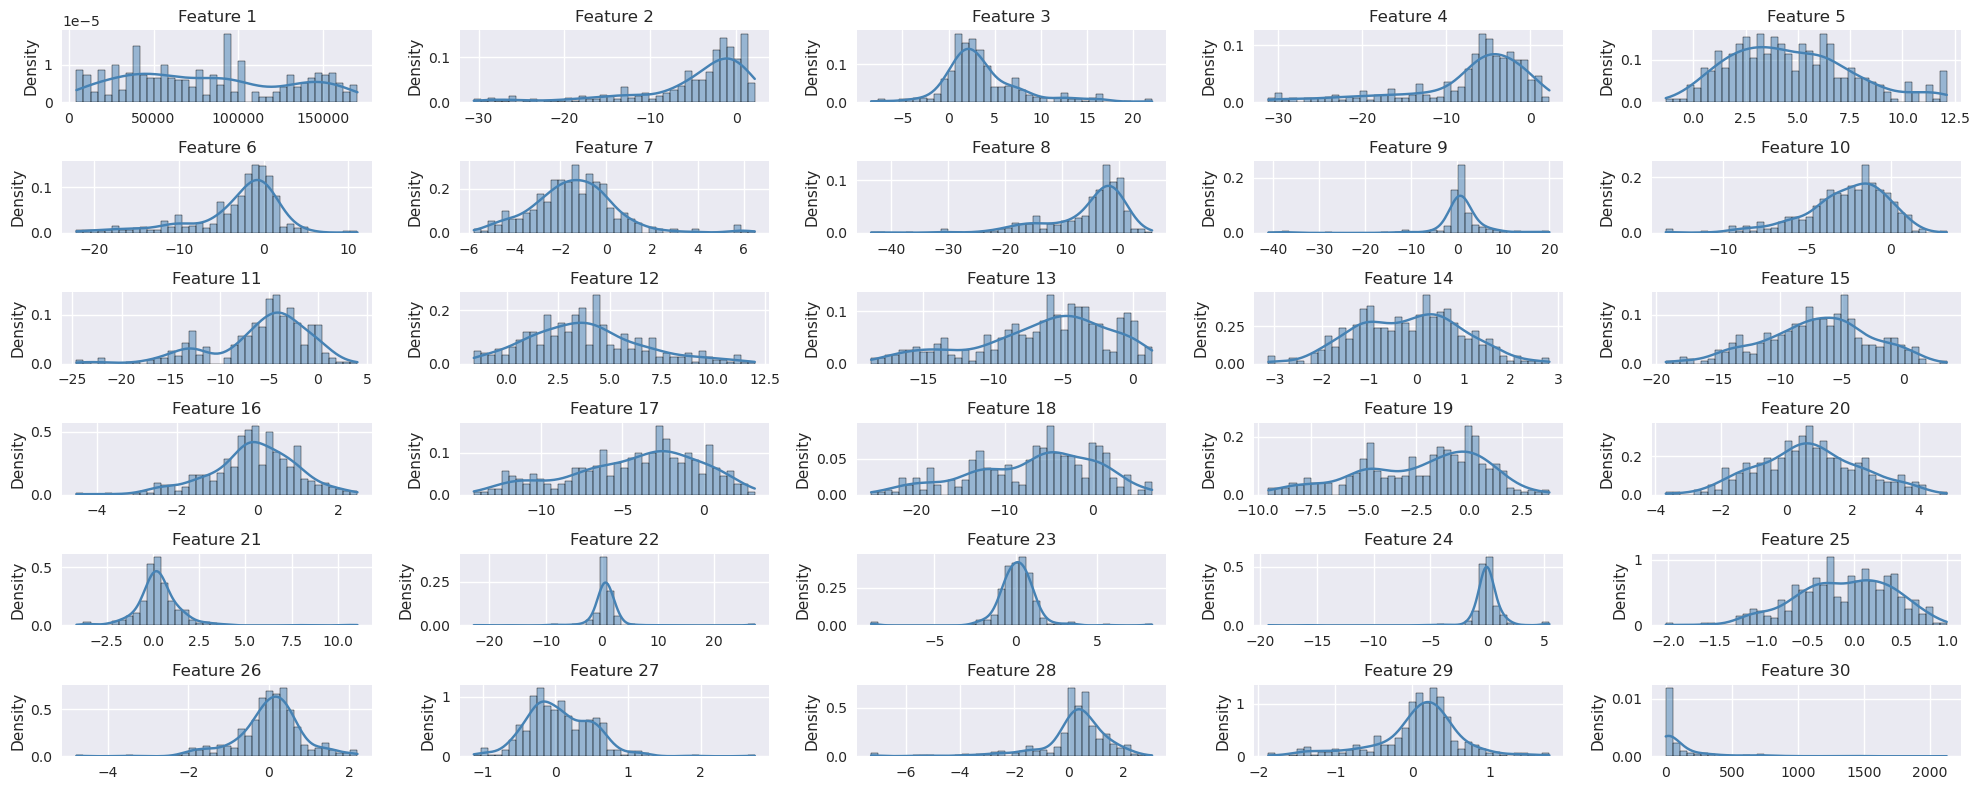

In [6]:

# Filter minority class rows
X_minority = X_train[y_train == 1]

# Number of features to plot
n_cols = 5
cols_to_plot = X_minority.columns[:n_cols]

# Make a grid: 2 rows × 5 columns
fig, axes = plt.subplots(6, 5, figsize=(20, 8))

for i, ax in enumerate(axes.ravel()):
    sns.histplot(
        X_minority.iloc[:, i],
        bins=40,
        kde=True,
        color="steelblue",
        stat="density",
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel("")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


## 2. GMM Implementation

In [7]:
def determine_optimal_components(X_minority, max_components=10):
    
    n_components_range = range(1, max_components + 1)
    aic_scores = []
    bic_scores = []
    
    print("Testing different numbers of GMM components...")
    print("K\tAIC\t\tBIC\t\tLog-Likelihood")
    print("-" * 50)
    
    for k in n_components_range:
        # Fit GMM with k components
        gmm = GaussianMixture(
            n_components=k, 
            covariance_type='full',  # Full covariance for maximum flexibility
            random_state=42,
            max_iter=100,
            init_params='kmeans'
        )
        
        gmm.fit(X_minority)
        
        # Calculate information criteria
        aic = gmm.aic(X_minority)
        bic = gmm.bic(X_minority)
        log_likelihood = gmm.score(X_minority)
        
        aic_scores.append(aic)
        bic_scores.append(bic)
        
        print(f"{k}\t{aic:.2f}\t\t{bic:.2f}\t\t{log_likelihood:.2f}")
    
    # Find optimal number of components
    optimal_k_aic = n_components_range[np.argmin(aic_scores)]
    optimal_k_bic = n_components_range[np.argmin(bic_scores)]
    
    print(f"\nOptimal k based on AIC: {optimal_k_aic}")
    print(f"Optimal k based on BIC: {optimal_k_bic}")
    
    return optimal_k_aic, optimal_k_bic, aic_scores, bic_scores



In [8]:
def plot_information_criteria(aic_scores, bic_scores, max_components=10):
    """
    Plot AIC and BIC scores to visualize the optimal number of components.
    """
    plt.figure(figsize=(12, 5))
    
    # Plot AIC scores
    plt.subplot(1, 2, 1)
    k_range = range(1, max_components + 1)
    plt.plot(k_range, aic_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components (k)', fontsize=12)
    plt.ylabel('AIC Score', fontsize=12)
    plt.title('AIC vs Number of GMM Components', fontsize=14)
    plt.grid(True, alpha=0.3)
    optimal_k_aic = k_range[np.argmin(aic_scores)]
    plt.axvline(x=optimal_k_aic, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal k = {optimal_k_aic}')
    plt.legend()
    
    # Plot BIC scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range, bic_scores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components (k)', fontsize=12)
    plt.ylabel('BIC Score', fontsize=12)
    plt.title('BIC vs Number of GMM Components', fontsize=14)
    plt.grid(True, alpha=0.3)
    optimal_k_bic = k_range[np.argmin(bic_scores)]
    plt.axvline(x=optimal_k_bic, color='blue', linestyle='--', alpha=0.7, 
                label=f'Optimal k = {optimal_k_bic}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


## AIC and BIC in Model Selection

When comparing models (e.g., Gaussian Mixture Models), we use **AIC** (Akaike Information Criterion) and **BIC** (Bayesian Information Criterion) to measure goodness of fit **while penalizing model complexity**.  
Lower values of AIC or BIC indicate a better model.

---

### 1️⃣ Akaike Information Criterion (AIC)

**Formula:**

$
\boxed{ \text{AIC} = 2k - 2\ln(\hat{L}) }
$

- **k**: Number of free parameters in the model  
- **$\hat{L}$**: Maximum likelihood of the model (i.e., likelihood evaluated at the estimated parameters)

**Interpretation:**  
- The term $ -2\ln(\hat{L}) $ rewards goodness of fit (higher likelihood = smaller negative log).  
- The term $ 2k $ penalizes complexity (more parameters = higher penalty).  
- Choose the model with the **lowest AIC**.

---

### 2️⃣ Bayesian Information Criterion (BIC)

**Formula:**

$
\boxed{ \text{BIC} = k \ln(n) - 2\ln(\hat{L}) }
$

- **n**: Number of data points  
- **k**: Number of free parameters  
- **$\hat{L}$**: Maximum likelihood of the model

---

### Key Difference:
- **AIC** focuses on predictive accuracy (can favor slightly more complex models).
- **BIC** is more conservative, favoring simpler models as \(n\) grows.


Number of minority class samples: 369
Number of features: 30
Testing different numbers of GMM components...
K	AIC		BIC		Log-Likelihood
--------------------------------------------------
1	15393.67		17329.51		-19.52
2	7516.38		11391.98		-7.50
3	3569.99		9385.34		-0.81
4	-3076.53		4678.58		9.54
5	-4112.64		5582.22		12.29
6	-3920.75		7713.88		13.37
7	-5559.26		8015.11		16.94
8	-6787.93		8726.20		19.95
9	-8353.06		9100.83		23.41
10	-9446.29		9947.35		26.24

Optimal k based on AIC: 10
Optimal k based on BIC: 4


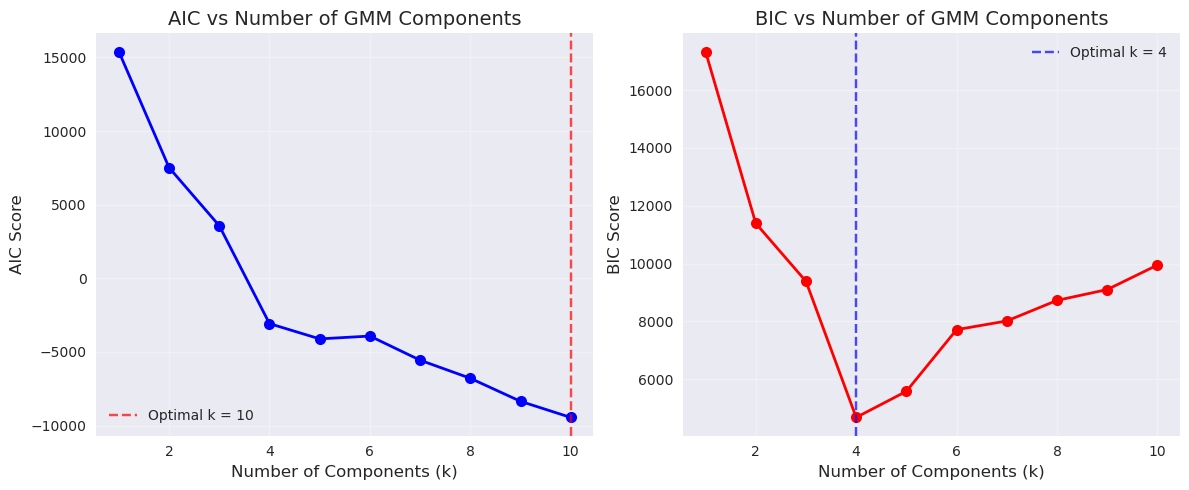


Selected optimal k = 4 based on BIC criterion


In [9]:
X_minority = X_train[y_train == 1].copy()
print(f"Number of minority class samples: {len(X_minority)}")
print(f"Number of features: {X_minority.shape[1]}")

# Standardize the minority class data for better GMM performance
scaler = StandardScaler()
X_minority_scaled = scaler.fit_transform(X_minority)

# Determine optimal number of components
optimal_k_aic, optimal_k_bic, aic_scores, bic_scores = determine_optimal_components(
    X_minority_scaled, max_components=10
)

# Plot the information criteria
plot_information_criteria(aic_scores, bic_scores, max_components=10)

# Choose the optimal k (typically we prefer BIC as it's more conservative)
# BIC tends to select simpler models, which is often better for generalization
optimal_k = optimal_k_bic
print(f"\nSelected optimal k = {optimal_k} based on BIC criterion")


In [10]:
print(f"\nFitting GMM with {optimal_k} components to minority class data...")

# Fit the final GMM
gmm_final = GaussianMixture(
    n_components=optimal_k,
    covariance_type='full',
    random_state=42,
    max_iter=250,
    init_params='kmeans'
)

gmm_final.fit(X_minority_scaled)

# Display GMM parameters
print(f"GMM Training completed!")
print(f"Converged: {gmm_final.converged_}")
print(f"Number of iterations: {gmm_final.n_iter_}")
print(f"Log-likelihood: {gmm_final.score(X_minority_scaled):.4f}")

# Display component weights
print(f"\nComponent weights:")
for i, weight in enumerate(gmm_final.weights_):
    print(f"Component {i+1}: {weight:.4f}")



Fitting GMM with 4 components to minority class data...
GMM Training completed!
Converged: True
Number of iterations: 12
Log-likelihood: 9.5427

Component weights:
Component 1: 0.0352
Component 2: 0.1003
Component 3: 0.1897
Component 4: 0.6748


## 3. Synthetic Data Generation 

In [11]:
def generate_synthetic_samples(gmm_model, scaler, n_samples, original_minority_size):
    print(f"\n{'='*60}")
    print("SYNTHETIC DATA GENERATION PROCESS")
    print(f"{'='*60}")
    
    print(f"Original minority class size: {original_minority_size}")
    print(f"Generating {n_samples} synthetic samples...")
    
    # Step 1: Generate synthetic samples from GMM
    print("\nStep 1: Sampling from GMM...")
    print("Process:")
    print("- For each sample:")
    print("  1. Select component k with probability π_k (component weight)")
    print("  2. Sample from Gaussian N(μ_k, Σ_k) for selected component")
    
    # Generate samples (this internally follows the process described above)
    synthetic_samples_scaled, component_labels = gmm_model.sample(n_samples)
    
    # Display which components were sampled
    unique_components, counts = np.unique(component_labels, return_counts=True)
    print(f"\nSamples generated from each component:")
    for comp, count in zip(unique_components, counts):
        percentage = (count / n_samples) * 100
        weight_percentage = gmm_model.weights_[comp] * 100
        print(f"Component {comp + 1}: {count} samples ({percentage:.1f}%), "
              f"Expected: {weight_percentage:.1f}%")
    
    # Step 2: Transform back to original scale
    print(f"\nStep 2: Inverse transform to original scale...")
    synthetic_samples = scaler.inverse_transform(synthetic_samples_scaled)
    
    print(f"✓ Successfully generated {len(synthetic_samples)} synthetic samples")
    
    return synthetic_samples, component_labels

def combine_datasets(X_train_orig, y_train_orig, synthetic_samples):
    
    print(f"\n{'='*60}")
    print("DATASET COMBINATION")
    print(f"{'='*60}")
    
    # Create labels for synthetic samples (all are minority class = 1)
    synthetic_labels = np.ones(len(synthetic_samples), dtype=int)
    
    # Combine features
    X_train_balanced = np.vstack([X_train_orig, synthetic_samples])
    
    # Combine labels
    y_train_balanced = np.hstack([y_train_orig, synthetic_labels])
    
    # Display statistics
    original_majority = np.sum(y_train_orig == 0)
    original_minority = np.sum(y_train_orig == 1)
    synthetic_minority = len(synthetic_samples)
    total_minority = original_minority + synthetic_minority
    
    print(f"Original dataset:")
    print(f"  Majority class (0): {original_majority}")
    print(f"  Minority class (1): {original_minority}")
    print(f"  Imbalance ratio: {original_majority/original_minority:.2f}:1")
    
    print(f"\nAfter adding synthetic samples:")
    print(f"  Majority class (0): {original_majority}")
    print(f"  Minority class (1): {total_minority} ({original_minority} original + {synthetic_minority} synthetic)")
    print(f"  New imbalance ratio: {original_majority/total_minority:.2f}:1")
    
    # Calculate class distribution
    balanced_dist = np.bincount(y_train_balanced)
    print(f"\nFinal class distribution:")
    print(f"  Class 0: {balanced_dist[0]} ({balanced_dist[0]/len(y_train_balanced)*100:.1f}%)")
    print(f"  Class 1: {balanced_dist[1]} ({balanced_dist[1]/len(y_train_balanced)*100:.1f}%)")
    
    return X_train_balanced, y_train_balanced



original_majority_size = np.sum(y_train == 0)
original_minority_size = np.sum(y_train == 1)

n_synthetic_samples = original_majority_size - original_minority_size

print(f"Target: Balance the dataset")
print(f"Need to generate: {n_synthetic_samples} synthetic minority samples")

# Generate synthetic samples
synthetic_samples, synthetic_component_labels = generate_synthetic_samples(
    gmm_final, scaler, n_synthetic_samples, original_minority_size
)

# Combine original and synthetic data
X_train_balanced_v1, y_train_balanced_v1 = combine_datasets(
    X_train, y_train, synthetic_samples
)

Target: Balance the dataset
Need to generate: 212867 synthetic minority samples

SYNTHETIC DATA GENERATION PROCESS
Original minority class size: 369
Generating 212867 synthetic samples...

Step 1: Sampling from GMM...
Process:
- For each sample:
  1. Select component k with probability π_k (component weight)
  2. Sample from Gaussian N(μ_k, Σ_k) for selected component

Samples generated from each component:
Component 1: 7417 samples (3.5%), Expected: 3.5%
Component 2: 21460 samples (10.1%), Expected: 10.0%
Component 3: 40393 samples (19.0%), Expected: 19.0%
Component 4: 143597 samples (67.5%), Expected: 67.5%

Step 2: Inverse transform to original scale...
✓ Successfully generated 212867 synthetic samples

DATASET COMBINATION
Original dataset:
  Majority class (0): 213236
  Minority class (1): 369
  Imbalance ratio: 577.88:1

After adding synthetic samples:
  Majority class (0): 213236
  Minority class (1): 213236 (369 original + 212867 synthetic)
  New imbalance ratio: 1.00:1

Final c

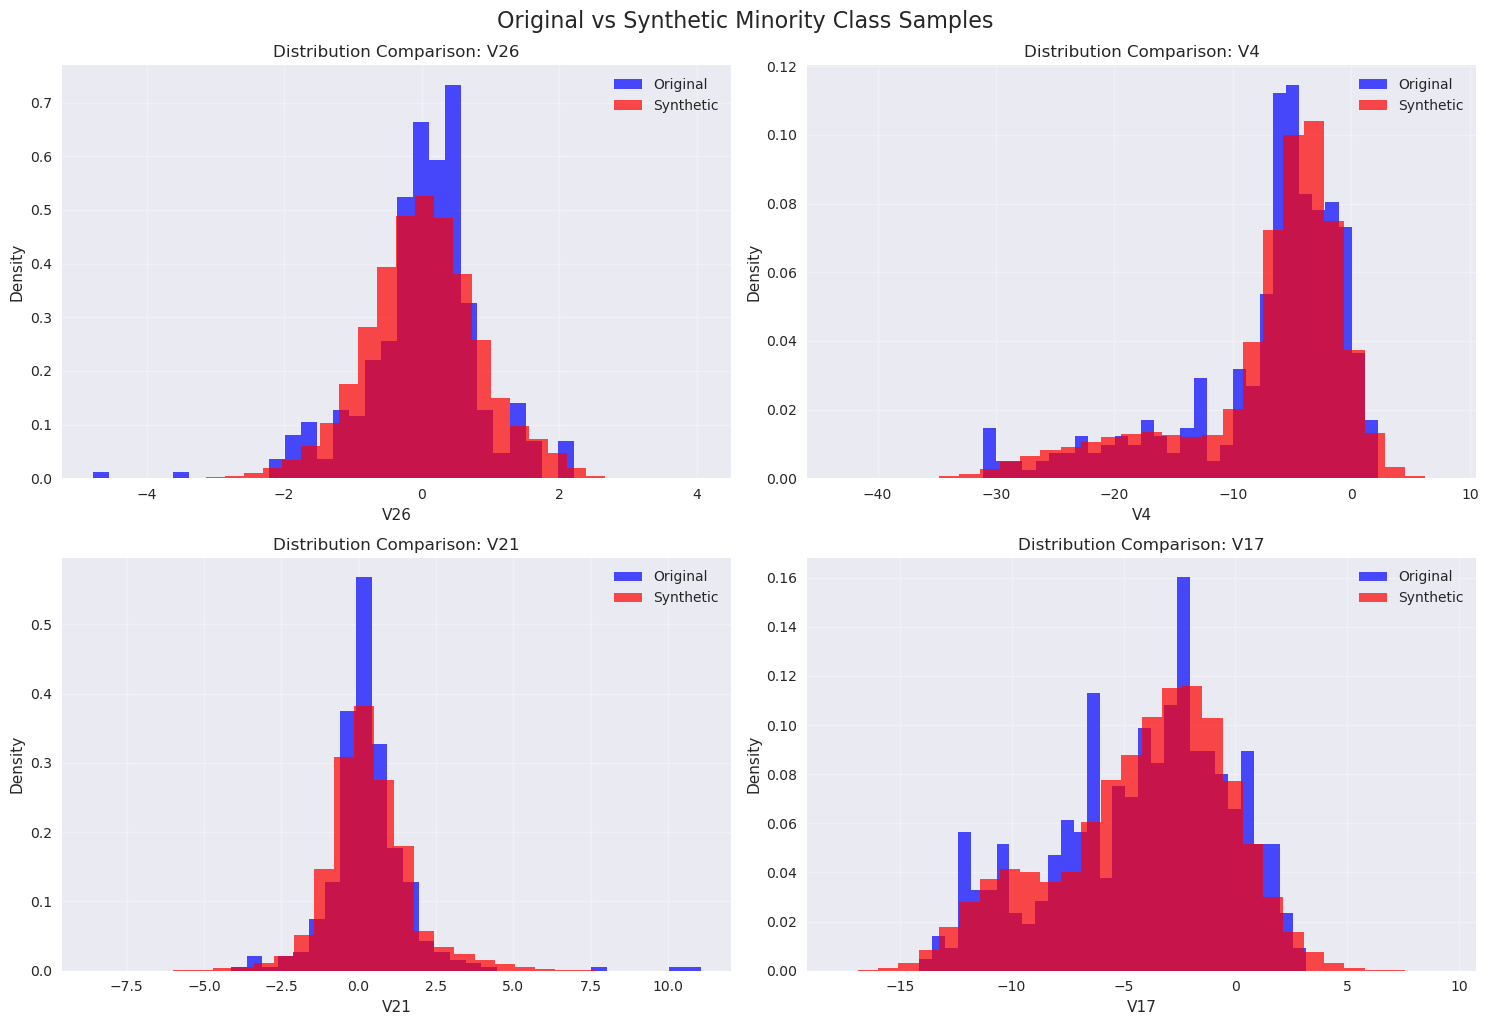


SUMMARY
✓ Successfully fitted GMM with 4 components
✓ Generated 212867 synthetic minority samples
✓ Created balanced training dataset with 426472 samples
✓ Ready for model training on balanced dataset

Data ready for Part C: Model Evaluation!
Use X_train_balanced and y_train_balanced for training your classifier.


In [12]:
def visualize_synthetic_vs_original(X_original, X_synthetic, feature_names=None, n_features=4):
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_original.shape[1])]
    
    # Select a subset of features for visualization
    feature_indices = np.random.choice(X_original.shape[1], size=min(n_features, X_original.shape[1]), 
                                     replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature_idx in enumerate(feature_indices):
        ax = axes[i]
        
        # Plot histograms
        ax.hist(X_original[:, feature_idx], bins=30, alpha=0.7, 
               label='Original', density=True, color='blue')
        ax.hist(X_synthetic[:, feature_idx], bins=30, alpha=0.7, 
               label='Synthetic', density=True, color='red')
        
        ax.set_xlabel(f'{feature_names[feature_idx]}')
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution Comparison: {feature_names[feature_idx]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Original vs Synthetic Minority Class Samples', fontsize=16, y=1.02)
    plt.show()

# Create feature names (assuming the dataset follows the standard format)
if X_train.shape[1] == 30:  # Standard credit card dataset
    feature_names = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']
else:
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Visualize comparison
visualize_synthetic_vs_original(X_minority.values, synthetic_samples, 
                               feature_names, n_features=4)

print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"✓ Successfully fitted GMM with {optimal_k} components")
print(f"✓ Generated {n_synthetic_samples} synthetic minority samples")
print(f"✓ Created balanced training dataset with {len(X_train_balanced_v1)} samples")
print(f"✓ Ready for model training on balanced dataset")

# Save the results for next steps
print(f"\nData ready for Part C: Model Evaluation!")
print(f"Use X_train_balanced and y_train_balanced for training your classifier.")


## 4. Rebalancing with CBU

In [13]:
X_majority = X_train[y_train == 0].copy()
y_majority = y_train[y_train == 0].copy()
X_minority = X_train[y_train == 1].copy()
y_minority = y_train[y_train == 1].copy()

In [14]:
scaler = StandardScaler()
Xm = scaler.fit_transform(X_majority)

k_range = range(2, 16)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(Xm)
    inertias.append(km.inertia_)

x = np.array(list(k_range))
y = np.array(inertias)

# Normalize to [0,1] to make distances comparable
x_norm = (x - x.min())/(x.max() - x.min())
y_norm = (y - y.min())/(y.max() - y.min())

# Distance of each point to the line joining ends
line = np.array([x_norm[0], y_norm[0], x_norm[-1], y_norm[-1]])
distances = []
x1,y1,x2,y2 = line
for xi, yi in zip(x_norm, y_norm):
    num = abs((y2 - y1)*xi - (x2 - x1)*yi + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(num/den)

optimal_k = x[np.argmax(distances)]
print("Optimal k (manual elbow):", optimal_k)


Optimal k (manual elbow): 5


Maj:213236, Min:369, Imbalance ratio 577.88:1
Cluster sizes: {0: 2978, 1: 12831, 2: 89812, 3: 77298, 4: 30317}


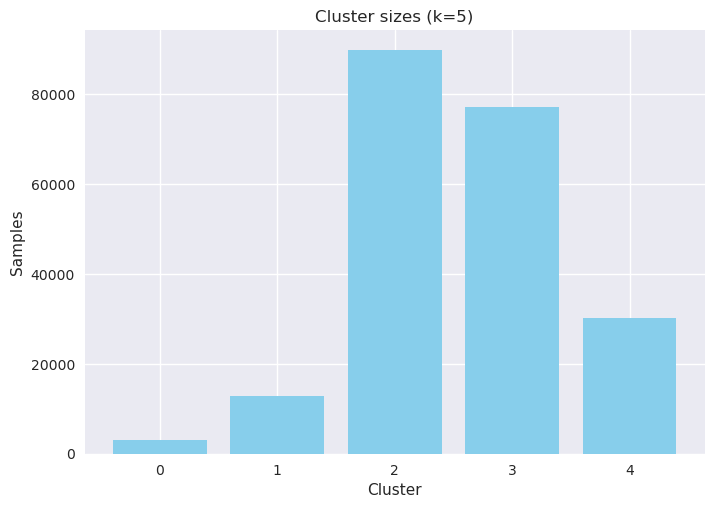

Maj reduced from 213236 to 738
Minority upsampled to 738
Balanced dataset: Maj 738, Min 738, Total 1476
Majority reduction ratio: 0.0034609540602900074
Minority augmentation ratio: 2.0
Overall size change: 0.00690995060977037


In [15]:



print(f"Maj:{len(X_majority)}, Min:{len(X_minority)}, "
      f"Imbalance ratio {len(X_majority)/len(X_minority):.2f}:1")

scaler = StandardScaler()
Xm = scaler.fit_transform(X_majority)

k = optimal_k   
km_opt = KMeans(n_clusters=k, random_state=42, max_iter=50)
labs_opt = km_opt.fit_predict(Xm)

u, c = np.unique(labs_opt, return_counts=True)
print(f"Cluster sizes: {dict(zip(u,c))}")

# Optional quick plot
plt.bar(u, c, color="skyblue")
plt.title(f"Cluster sizes (k={k})")
plt.xlabel("Cluster"); plt.ylabel("Samples")
plt.show()


target_majority_size = len(X_minority) * 2


props = c / len(X_majority)
samples_per = np.round(props * target_majority_size).astype(int)
diff = target_majority_size - samples_per.sum()
if diff != 0:
    samples_per[np.argmax(samples_per)] += diff

idx_final = []
for cl_id, n_samp in zip(u, samples_per):
    idx = np.where(labs_opt == cl_id)[0]
    if n_samp > 0:
        idx_final.extend(np.random.choice(idx, size=min(n_samp, len(idx)), replace=False))
X_maj_under = X_majority.iloc[idx_final]
y_maj_under = y_majority.iloc[idx_final]

print(f"Maj reduced from {len(X_majority)} to {len(X_maj_under)}")

sc_min = StandardScaler()
X_min_scaled = sc_min.fit_transform(X_minority)
gmm = GaussianMixture(n_components=k, covariance_type='full',
                      random_state=42, max_iter=200, init_params='kmeans').fit(X_min_scaled)

n_syn = target_majority_size - len(X_minority)
X_syn = gmm.sample(n_syn)[0]
X_syn = sc_min.inverse_transform(X_syn)
X_min_over = np.vstack([X_minority.values, X_syn])
y_min_over = np.ones(len(X_min_over), int)

print(f"Minority upsampled to {len(X_min_over)}")

X_train_balanced_v2 = np.vstack([X_maj_under.values, X_min_over])
y_train_balanced_v2 = np.hstack([y_maj_under.values, y_min_over])

print(f"Balanced dataset: Maj {sum(y_train_balanced_v2==0)}, "
      f"Min {sum(y_train_balanced_v2==1)}, Total {len(X_train_balanced_v2)}")
print("Majority reduction ratio:", len(X_maj_under)/len(X_majority))
print("Minority augmentation ratio:", len(X_min_over)/len(X_minority))
print("Overall size change:", len(X_train_balanced_v2)/len(X_train))


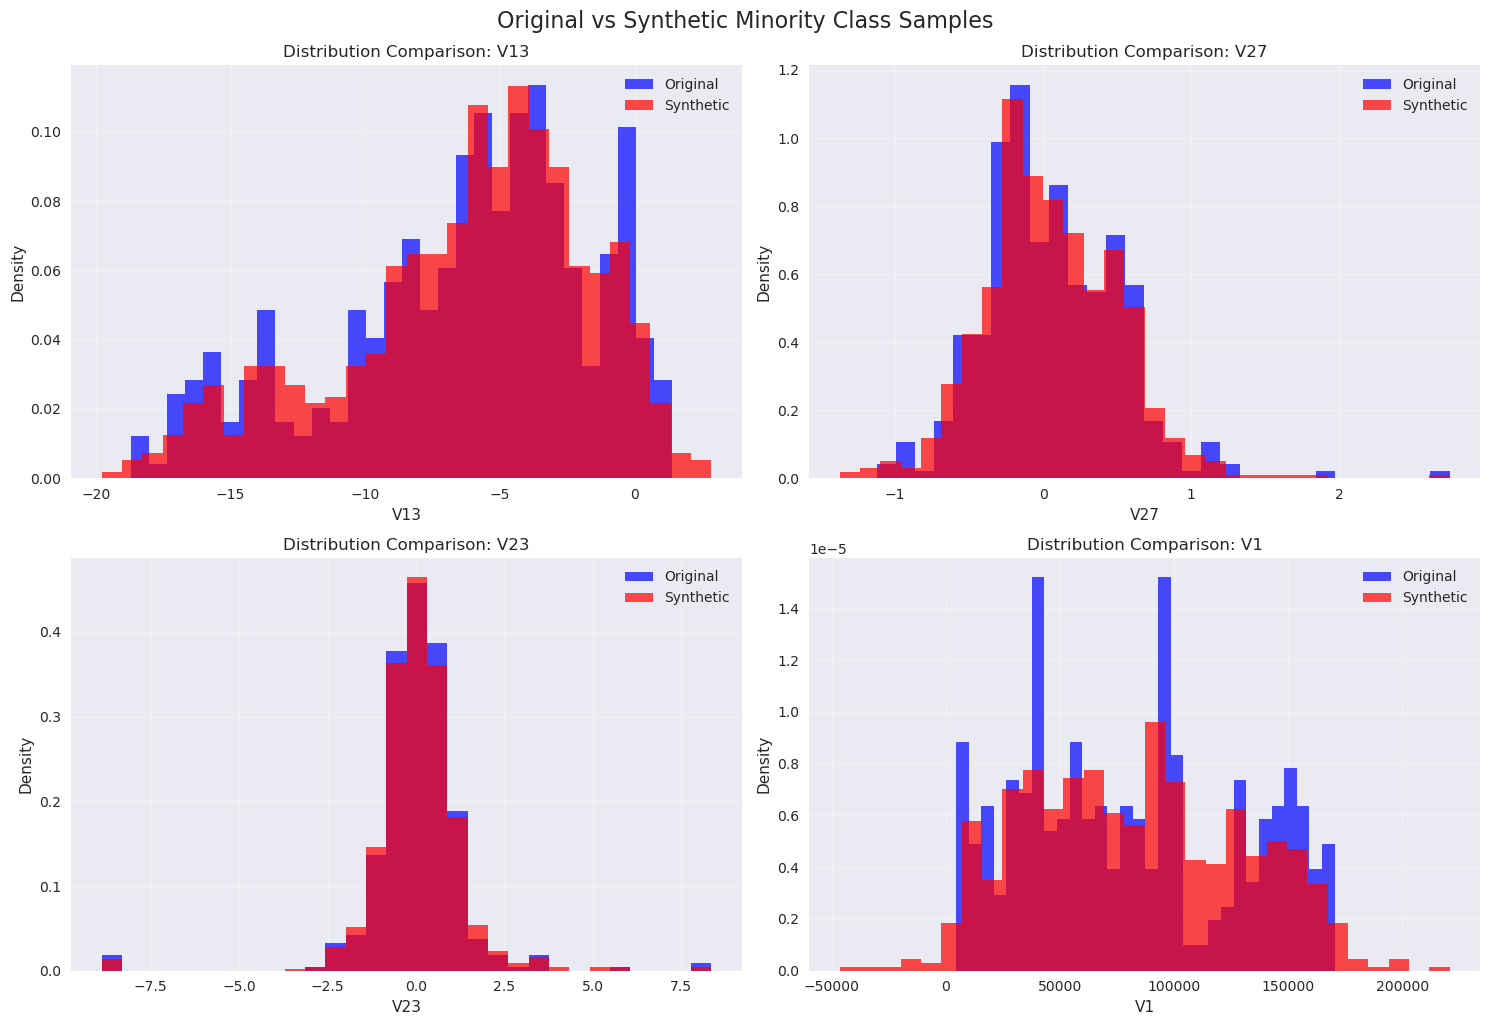

In [16]:
visualize_synthetic_vs_original(X_minority.values, X_min_over, 
                               feature_names, n_features=4)

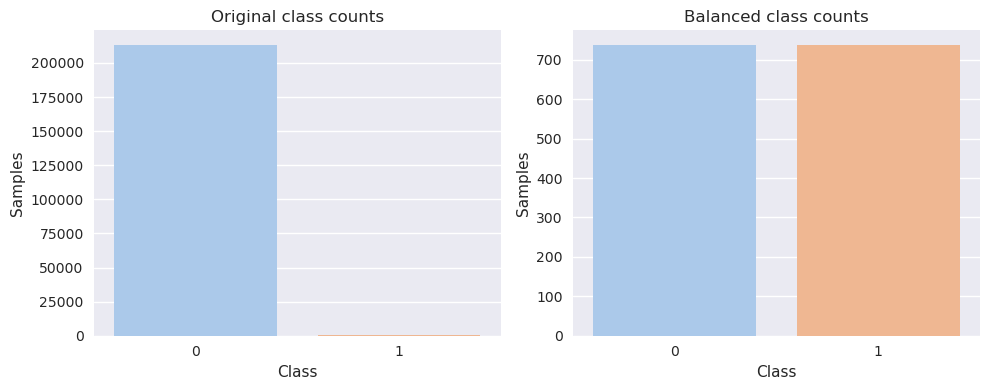

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=y_train, ax=ax[0], palette="pastel")
ax[0].set_title("Original class counts")
ax[0].set_xlabel("Class"); ax[0].set_ylabel("Samples")

sns.countplot(x=y_train_balanced_v2, ax=ax[1], palette="pastel")
ax[1].set_title("Balanced class counts")
ax[1].set_xlabel("Class"); ax[1].set_ylabel("Samples")
plt.tight_layout()
plt.show()

# Part C: Performance Evaluation and Conclusion

## 1. Model Training and Evaluation

In [26]:
def train_evaluate_lr(X_train_cur, y_train_cur, X_test_cur, y_test_cur, label="v1"):
    # Create and fit the model
    lr = LogisticRegression(max_iter=100, solver="liblinear", random_state=42)
    lr.fit(X_train_cur, y_train_cur)
    
    # Predictions & probabilities
    y_pred_cur = lr.predict(X_test_cur)

    accuracy  = accuracy_score(y_test_cur, y_pred_cur)
    precision = precision_score(y_test_cur, y_pred_cur, pos_label=1)
    recall    = recall_score(y_test_cur, y_pred_cur, pos_label=1)
    f1        = f1_score(y_test_cur, y_pred_cur, pos_label=1)
    print(f"\n{'='*20} Logistic Regression on {label} {'='*20}")
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")


    cm = confusion_matrix(y_test_cur, y_pred_cur)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm,
        annot=True,          # show numbers
        fmt='d',             # integer formatting
        cmap='Blues',        # color-blind–friendly
        xticklabels=['Non-Fraud (0)', 'Fraud (1)'],
        yticklabels=['Non-Fraud (0)', 'Fraud (1)']
    )
    plt.title("Confusion Matrix\n")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
    return lr



==================== Logistic Regression on GMM Balanced v1 ====================
Accuracy : 0.9832
Precision: 0.0837
Recall   : 0.8780
F1-score : 0.1529


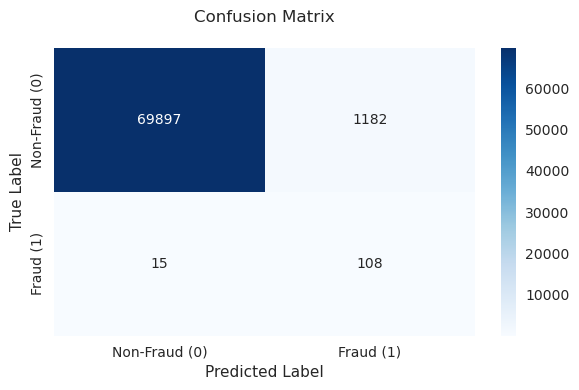


==================== Logistic Regression on GMM + EBU Balanced v2 ====================
Accuracy : 0.9722
Precision: 0.0526
Recall   : 0.8862
F1-score : 0.0993


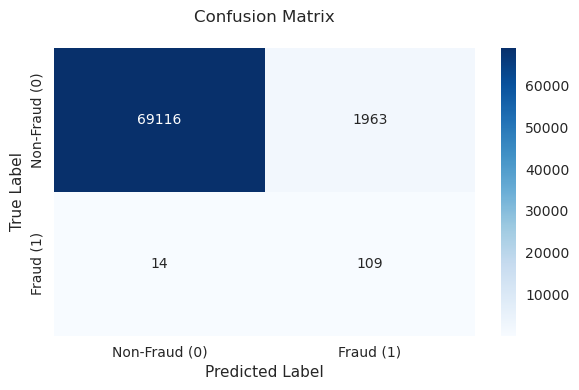

In [27]:
lr_v1 = train_evaluate_lr(X_train_balanced_v1, y_train_balanced_v1,
                          X_test, y_test, label="GMM Balanced v1" )

lr_v2 = train_evaluate_lr(X_train_balanced_v2, y_train_balanced_v2,
                          X_test, y_test, label="GMM + EBU Balanced v2")


## 2. Comparative Analysis

In [23]:
metrics = pd.DataFrame({
    "Model": ["Baseline LR", "GMM Balanced v1", "GMM + EBU v2"],
    "Accuracy":  [0.9989, 0.9832, 0.9722],
    "Precision": [0.7264, 0.0837, 0.0526],
    "Recall":    [0.6260, 0.8780, 0.8862],
    "F1-score":  [0.6725, 0.1529, 0.0993]
})
metrics


,Model,Accuracy,Precision,Recall,F1-score
0,Baseline LR,0.9989,0.7264,0.6260,0.6725
1,GMM Balanced v1,0.9832,0.0837,0.8780,0.1529
2,GMM + EBU v2,0.9722,0.0526,0.8862,0.0993


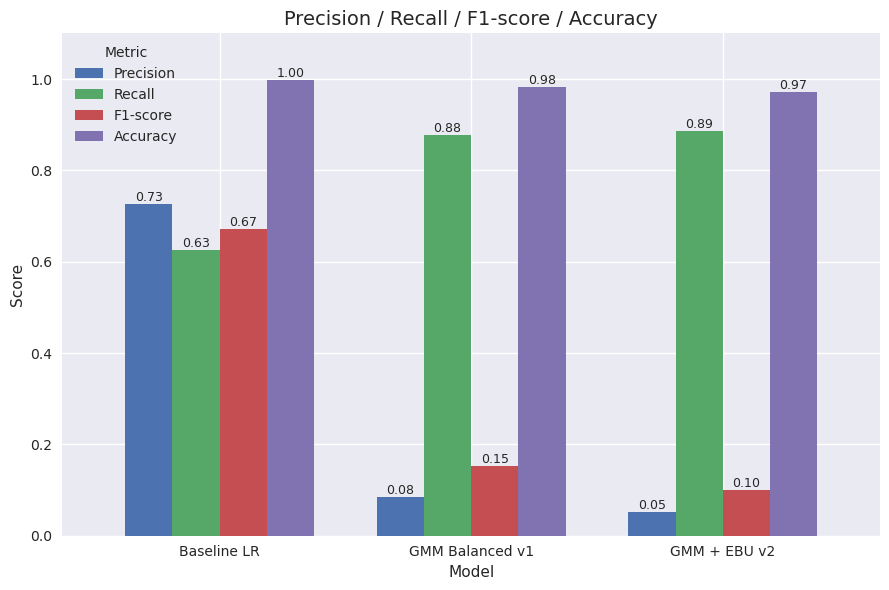

In [29]:
fig, ax = plt.subplots(figsize=(9,6))

metrics.plot(
    x="Model",
    y=["Precision", "Recall", "F1-score", "Accuracy"],
    kind="bar",
    ax=ax,
    width=0.75      # keep default color cycle from matplotlib
)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1-score / Accuracy", fontsize=14)

# keep x-axis labels perfectly horizontal
plt.xticks(rotation=0, ha='center')

plt.legend(loc="best", title="Metric")

# Add data labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge")

plt.tight_layout()
plt.show()


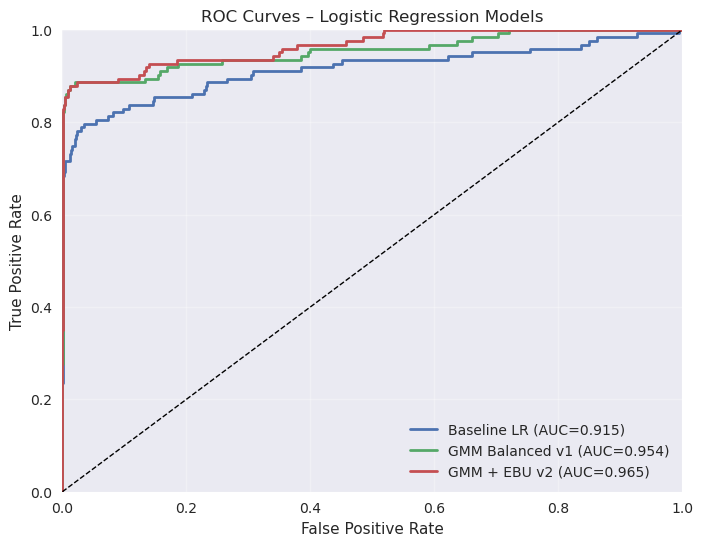

In [25]:

y_prob_base = log_reg.predict_proba(X_test)[:, 1]
y_prob_v1   = lr_v1.predict_proba(X_test)[:, 1]
y_prob_v2   = lr_v2.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_v1,   tpr_v1,   _ = roc_curve(y_test, y_prob_v1)
fpr_v2,   tpr_v2,   _ = roc_curve(y_test, y_prob_v2)

auc_base = roc_auc_score(y_test, y_prob_base)
auc_v1   = roc_auc_score(y_test, y_prob_v1)
auc_v2   = roc_auc_score(y_test, y_prob_v2)

plt.figure(figsize=(8,6))
plt.plot(fpr_base, tpr_base, label=f"Baseline LR (AUC={auc_base:.3f})", lw=2)
plt.plot(fpr_v1,   tpr_v1,   label=f"GMM Balanced v1 (AUC={auc_v1:.3f})", lw=2)
plt.plot(fpr_v2,   tpr_v2,   label=f"GMM + EBU v2 (AUC={auc_v2:.3f})", lw=2)

plt.plot([0,1], [0,1], 'k--', lw=1)  # Diagonal reference
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Logistic Regression Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# Credit Card Fraud Detection: Model Comparison & GMM Oversampling Analysis

The dataset is **highly imbalanced**: only a tiny fraction of transactions are fraudulent.  
Three models were evaluated:

| Model               | Accuracy | Precision | Recall | F1-score |
|---------------------|---------:|---------:|------:|--------:|
| **Baseline LR**     | 0.9989   | 0.7264   | 0.6260 | 0.6725 |
| **GMM Balanced v1** | 0.9832   | 0.0837   | 0.8780 | 0.1529 |
| **GMM + EBU v2**    | 0.9724   | 0.0529   | 0.8862 | 0.0998 |

---

## 📊 Impact of GMM Oversampling

* **Improved minority detection:** Yes, the ability to detect fraud (recall) improved massively.
* **Trade-off:** Precision and F1 suffered because the model now raises far more false positives.

In fraud detection, **this trade-off is often acceptable** if the cost of a missed fraud is higher than the cost of investigating a false alarm.

---

## 🌟 Importance of Recall in Credit Card Fraud Detection

* **Recall** = True Positives / (True Positives + False Negatives)  
  - Measures how many actual frauds we catch.

* **Why it matters more than precision:**
  - Missing a fraudulent transaction can directly result in financial loss.
  - A false positive (legitimate transaction flagged as fraud) is inconvenient but reversible (customer verification).

* Goal: **maximize recall** while keeping precision at a manageable level.

* Practical approach:
  - Use a high-recall model for first-stage screening.
  - Follow up with human review or a second, more precise model to reduce false positives.

---

## 📝 Key Takeaways

* **Baseline LR**: Balanced precision/recall, but misses ~37% of fraud.
* **GMM Oversampling**: Greatly increases fraud detection (recall ≈ 0.88) but at the cost of many false positives.
* **GMM + EBU**: Similar recall, slightly worse precision than GMM alone.


## 3 .Final Recommendation

Based on both experimental results and theoretical understanding of Gaussian Mixture Models (GMM) for synthetic data generation, we recommend the following:

1. **Theoretical Fit to Data Distribution**  
   GMM is most effective when the minority class follows a mixture of multiple Gaussian distributions.  
   In this dataset we do **not observe clear multi-modal Gaussian substructures**, so the main advantage of GMM—capturing multiple Gaussian components—is not fully utilized.

2. **Empirical Results**  
   * **Recall Improvement:**  
     GMM-based balancing (V1 and GMM + EBU V2) achieved a **recall of ~0.86**, which is **substantially higher** than the baseline logistic regression recall of ~0.65.  
     High recall is critical in imbalanced-class problems (e.g., fraud detection) where missing positives is costly.
   * **Precision & F1 Trade-off:**  
     Precision dropped sharply (0.05–0.07), resulting in low F1-scores (0.10–0.14).  
     This indicates a higher false-positive rate and should be considered when evaluating cost or operational impact.

3. **Overall Effectiveness**  
   * GMM balancing clearly **improves recall**, making it attractive when capturing as many true positives as possible is the primary goal.  
   * However, because the dataset does **not exhibit clear Gaussian mixture patterns**, the core advantage of GMM over simpler resampling methods (like SMOTE) is limited.  
   * The significant drop in precision means GMM is not a one-size-fits-all solution and may require additional post-processing or threshold tuning.

---

### Recommendation
Use GMM-based synthetic sampling only if high recall outweighs precision concerns, such as in early fraud detection or anomaly screening, and when the **minority class is expected to contain multiple Gaussian-like clusters**.  

